<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Unet_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to one attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(1, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [5]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

In [6]:
# data
data_location =  "/content/drive/My Drive/Eye data segmentaion/diaretdb1_v_1_1/diaretdb1_v_1_1/resources/images/ddb1_fundusimages"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    print(dirName,subdirList,fileList)
    for filename in sorted(fileList):
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

/content/drive/My Drive/Eye data segmentaion/diaretdb1_v_1_1/diaretdb1_v_1_1/resources/images/ddb1_fundusimages [] ['image005.png', 'image003.png', 'image002.png', 'image004.png', 'image001.png', 'image008.png', 'image010.png', 'image011.png', 'image013.png', 'image007.png', 'image009.png', 'image006.png', 'image012.png', 'image016.png', 'image019.png', 'image015.png', 'image020.png', 'image014.png', 'image017.png', 'image021.png', 'image018.png', 'image025.png', 'image023.png', 'image024.png', 'image028.png', 'image022.png', 'image027.png', 'image026.png', 'image029.png', 'image030.png', 'image036.png', 'image034.png', 'image035.png', 'image040.png', 'image033.png', 'image032.png', 'image037.png', 'image031.png', 'image038.png', 'image041.png', 'image039.png', 'image054.png', 'image056.png', 'image045.png', 'image053.png', 'image046.png', 'image051.png', 'image048.png', 'image043.png', 'image050.png', 'image057.png', 'image042.png', 'image044.png', 'image055.png', 'image047.png', 'ima

In [7]:

data_location = "/content/drive/My Drive/Eye data segmentaion/diaretdb1_v_1_1/diaretdb1_v_1_1/resources/images/ddb1_groundtruth/hardexudates"
train_data_gt = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in sorted(fileList):
        if ".png" in filename.lower() :
            train_data_gt.append(os.path.join(dirName,filename))

In [8]:
mask=[]
data_location = "/content/drive/My Drive/Eye data segmentaion/diaretdb1_v_1_1/diaretdb1_v_1_1/resources/images/ddb1_fundusmask"
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".tif" in filename.lower() :
            mask.append(os.path.join(dirName,filename))

(1152, 1500, 4)
Reduced channels (1152, 1500, 3)
BGR fundus_mask


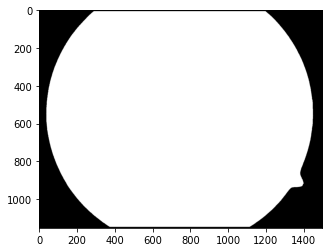

inverted fundus_mask


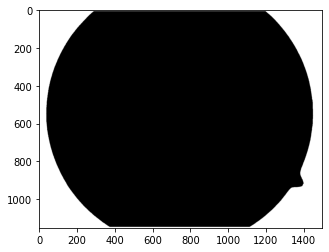

In [9]:
print(imread(mask[0]).shape)
img = cv2.cvtColor(imread(mask[0]), cv2.COLOR_BGRA2BGR)
print("Reduced channels",img.shape)
print("BGR fundus_mask")
plt.imshow(img)
plt.show()
print("inverted fundus_mask")
dst=255-img
plt.imshow(dst)
plt.show()

plot raw grountruth


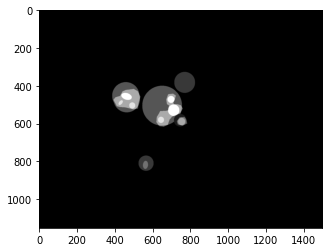

plot grayscale mask


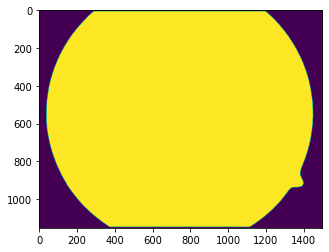

inverted grayscale fundus_mask


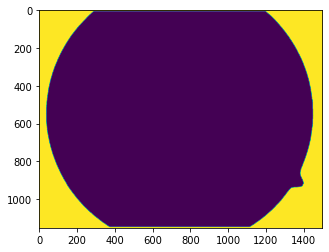

plot input image - fundus_mask  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


uint8 float32


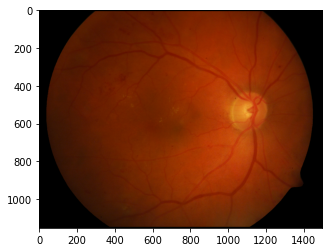

plot input image*255  
uint8 float32


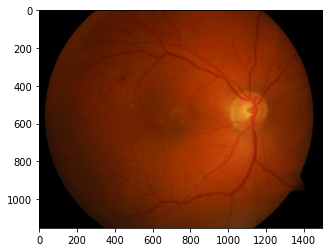

plot  groundtruth - grayscale fundus_mask 


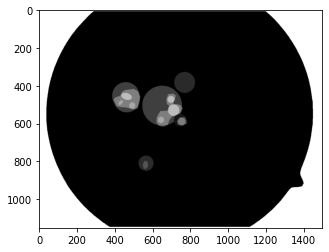

inverted groundtruth 


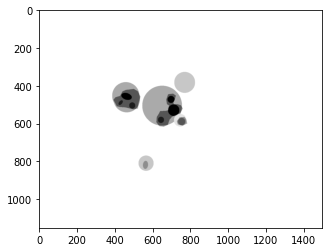

In [10]:
print("plot raw grountruth")
#train_img_gt and train_img is given in range 0-1
plt.imshow(255*imread(train_data_gt[2]),cmap='gray')
plt.show()

print("plot grayscale mask")
#img is in range 0-255
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)
plt.show()
print("inverted grayscale fundus_mask")
plt.imshow(255-gray_image)
plt.show()

print("plot input image - fundus_mask  ")
print(dst.dtype,imread(train_data[2]).dtype)
plt.imshow(((imread(train_data[2])*255).astype(int))-dst)
plt.show()

print("plot input image*255  ")
print(dst.dtype,imread(train_data[2]).dtype)
plt.imshow(((imread(train_data[2])*255).astype(int)))
plt.show()


#reduce img to 1d
print("plot  groundtruth - grayscale fundus_mask ")
plt.imshow((imread(train_data_gt[2])*255).astype(int)-gray_image+255,cmap='gray')
plt.show()
#nothing happened
#now invert the output mask would work as we are getting 0 class identified prominantly in the generated mask 
# we are doing 2 class clasification
print("inverted groundtruth ")
plt.imshow(255-imread(train_data_gt[2]),cmap='gray')
plt.show()

In [ ]:
"""train_images = np.zeros(shape=(89,512,512,3))
train_labels = np.zeros(shape=(89,512,512,1))
for file_index in range(len(train_data)):
    train_images[file_index,:,:]   = resize(imread(train_data[file_index]),(512,512))
    train_labels[file_index,:,:]   = np.expand_dims(resize(imread(train_data_gt[file_index]),(512,512)),axis=2)
    #train_images[k+1,:,:]   = resize(np.flip(imread(train_data[file_index]),axis=1),(512,512))
    #train_labels[k+1,:,:]   = np.expand_dims(resize(np.flip(imread(train_data_gt[file_index]),axis=1),(512,512)),axis=2)
    mask = train_labels[file_index,:,:]>0.5
    train_labels[file_index,:,:][mask] =1.00
train_images = (train_images)# - train_images.min()) / (train_images.max() - train_images.min())
train_labels = (train_labels)# - train_labels.min()) / (train_labels.max() - train_labels.min())
print(train_images.shape)
print(train_labels.shape)
num_epoch = 100

train_batch = train_images[:38*2]
train_label = train_labels[:38*2]
test_batch = train_images[75:89]
test_label = train_labels[75:89]

print(train_batch.shape)
print(train_label.shape)
print(test_batch.shape)
print(test_label.shape)"""
# discarded as most of the imags has not grund truth i.e. no hard ex

'train_images = np.zeros(shape=(89,512,512,3))\ntrain_labels = np.zeros(shape=(89,512,512,1))\nfor file_index in range(len(train_data)):\n    train_images[file_index,:,:]   = resize(imread(train_data[file_index]),(512,512))\n    train_labels[file_index,:,:]   = np.expand_dims(resize(imread(train_data_gt[file_index]),(512,512)),axis=2)\n    #train_images[k+1,:,:]   = resize(np.flip(imread(train_data[file_index]),axis=1),(512,512))\n    #train_labels[k+1,:,:]   = np.expand_dims(resize(np.flip(imread(train_data_gt[file_index]),axis=1),(512,512)),axis=2)\n    mask = train_labels[file_index,:,:]>0.5\n    train_labels[file_index,:,:][mask] =1.00\ntrain_images = (train_images)# - train_images.min()) / (train_images.max() - train_images.min())\ntrain_labels = (train_labels)# - train_labels.min()) / (train_labels.max() - train_labels.min())\nprint(train_images.shape)\nprint(train_labels.shape)\nnum_epoch = 100\n\ntrain_batch = train_images[:38*2]\ntrain_label = train_labels[:38*2]\ntest_batch =

In [11]:
hard_ex=[]
for i in range(1,28):
  hard_ex.append(i)
x=[35,38,44,53,54,66,67,71,84,85,86]
for i in x:
  hard_ex.append(i)
print("{} out of 89 has hard executes".format(len(hard_ex)))

38 out of 89 has hard executes


In [12]:
train_images = np.zeros(shape=(len(hard_ex)*2,512,512,3))
train_labels = np.zeros(shape=(len(hard_ex)*2,512,512,1))
k=0
for file_index in range(len(train_data)):
    if file_index+1 in hard_ex:
      train_images[k,:,:]   = resize(imread(train_data[file_index]),(512,512))
      train_labels[k,:,:]   = np.expand_dims(resize(imread(train_data_gt[file_index]),(512,512)),axis=2)
      train_images[k+1,:,:]   = resize(np.flip(imread(train_data[file_index]),axis=1),(512,512))
      train_labels[k+1,:,:]   = np.expand_dims(resize(np.flip(imread(train_data_gt[file_index]),axis=1),(512,512)),axis=2)
      mask = train_labels[k,:,:]>0.4
      train_labels[k,:,:][mask] =1.0
      train_labels[k,:,:][~mask] =0.0
      mask = train_labels[k+1,:,:]>0.4
      train_labels[k+1,:,:][mask] =1.0
      train_labels[k+1,:,:][~mask] =0.0
      k+=2
train_images = (train_images)# - train_images.min()) / (train_images.max() - train_images.min())
train_labels = (train_labels)# - train_labels.min()) / (train_labels.max() - train_labels.min())
print(train_images.shape)
print(train_labels.shape)

(76, 512, 512, 3)
(76, 512, 512, 1)


In [13]:
train_batch = train_images[:38*2]
train_label = train_labels[:38*2]
test_batch = train_images[36*2:38*2]
test_label = train_labels[36*2:38*2]

In [23]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size = 512
#train_path = "dataset/stage1_train/"
epochs = 100
batch_size = 2
model = UNet()
opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary() 

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 3)  84          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 512, 512, 3)  12          conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 512, 512, 3)  84          batch_normalization_38[0][0]     
_______________________________________________________________________________________

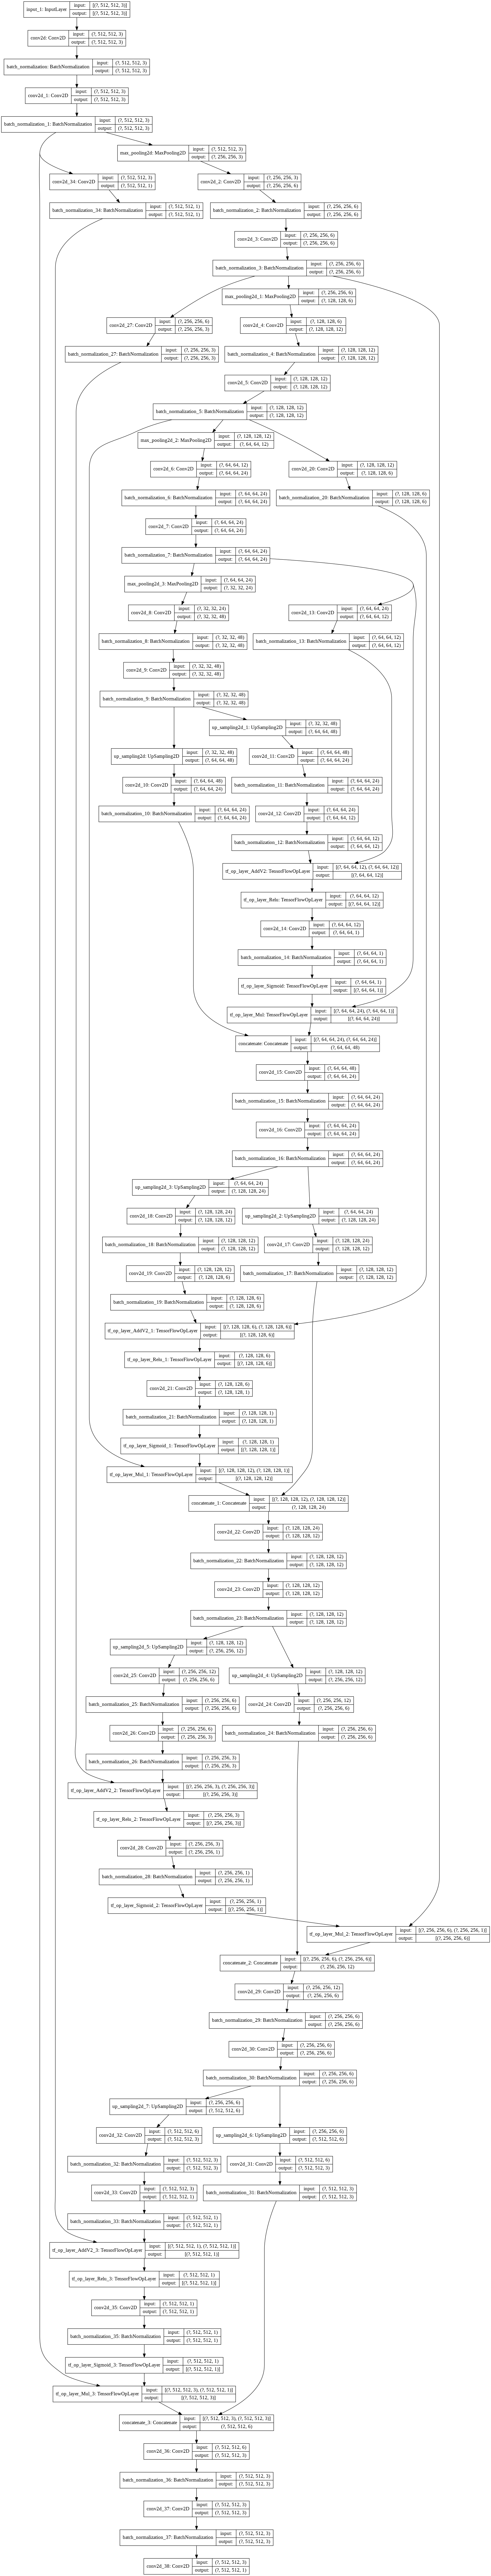

In [15]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96
)

In [24]:
hist=model.fit( x = train_batch, y = train_label, batch_size = 2, epochs = 30,verbose=1,validation_split=2/76,shuffle=True)

Epoch 1/30
37/37 [==============================] - 118s 3s/step - loss: 0.2672 - mean_io_u_1: 0.4699 - val_loss: 0.2171 - val_mean_io_u_1: 0.4996
Epoch 2/30
37/37 [==============================] - 117s 3s/step - loss: 0.2160 - mean_io_u_1: 0.4699 - val_loss: 0.2628 - val_mean_io_u_1: 0.4996
Epoch 3/30
37/37 [==============================] - 120s 3s/step - loss: 0.1842 - mean_io_u_1: 0.4699 - val_loss: 0.1700 - val_mean_io_u_1: 0.4996
Epoch 4/30
37/37 [==============================] - 117s 3s/step - loss: 0.1603 - mean_io_u_1: 0.4699 - val_loss: 0.1351 - val_mean_io_u_1: 0.4996
Epoch 5/30
37/37 [==============================] - 117s 3s/step - loss: 0.1374 - mean_io_u_1: 0.4699 - val_loss: 0.1085 - val_mean_io_u_1: 0.4996
Epoch 6/30
37/37 [==============================] - 117s 3s/step - loss: 0.1219 - mean_io_u_1: 0.4699 - val_loss: 0.0753 - val_mean_io_u_1: 0.4996
Epoch 7/30
37/37 [==============================] - 117s 3s/step - loss: 0.1067 - mean_io_u_1: 0.4699 - val_loss: 0.06

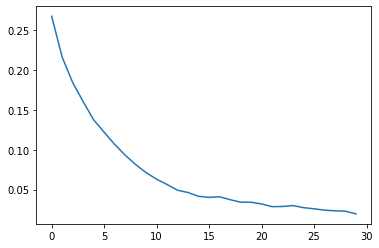

In [25]:
plt.plot(hist.history['loss'])

In [26]:
predicted_test_label=model.predict(test_batch)

(512, 512, 1)


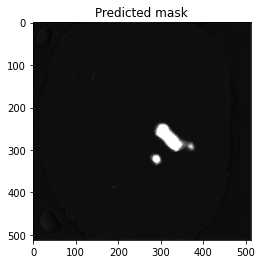

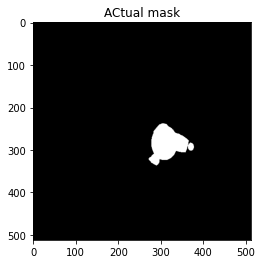

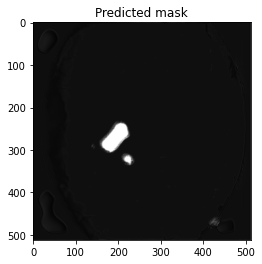

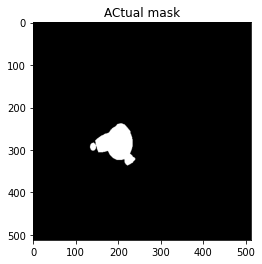

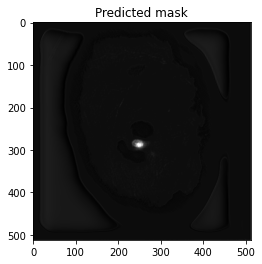

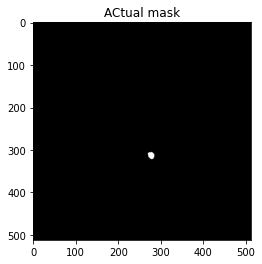

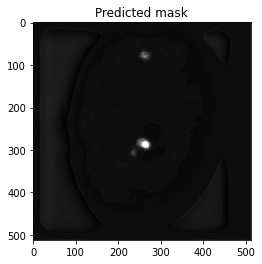

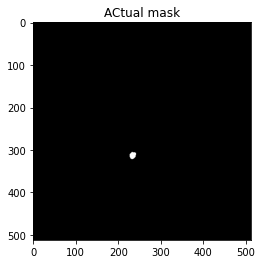

In [27]:
print(predicted_test_label[0].shape)
for i in range(4):
  plt.imshow(np.squeeze(predicted_test_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("Predicted mask")
  plt.show()
  plt.imshow(np.squeeze(test_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("ACtual mask")
  plt.show()

In [28]:
 predicted_train_label=model.predict(train_batch)

(512, 512, 1)
Predicted


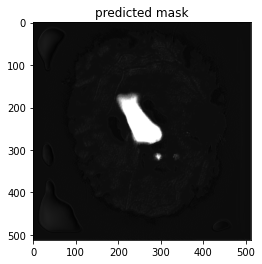

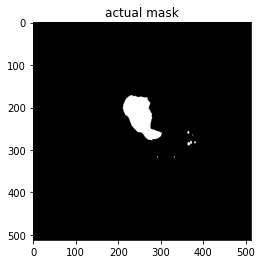

Predicted


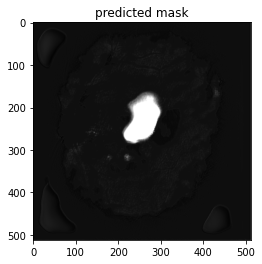

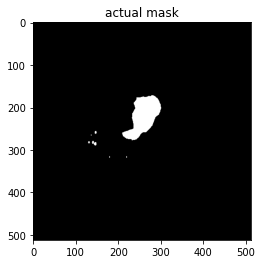

Predicted


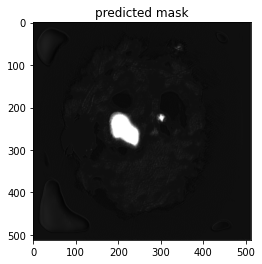

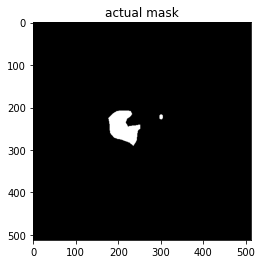

Predicted


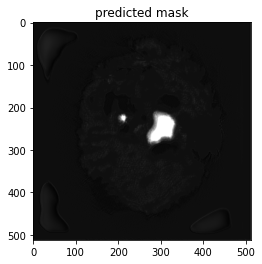

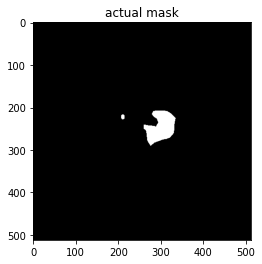

Predicted


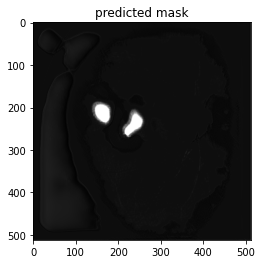

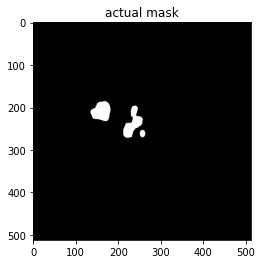

Predicted


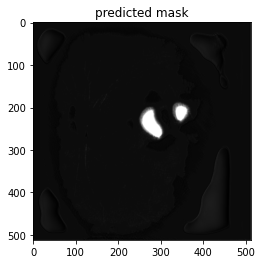

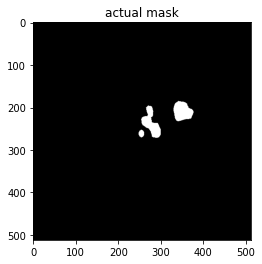

Predicted


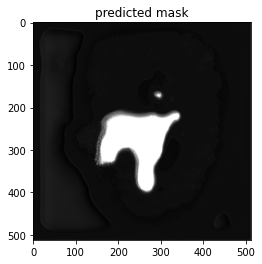

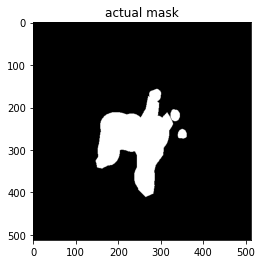

Predicted


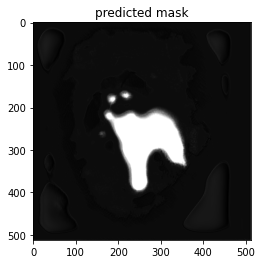

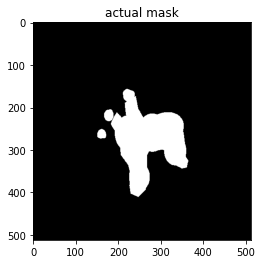

Predicted


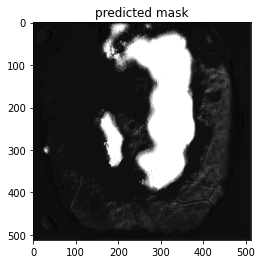

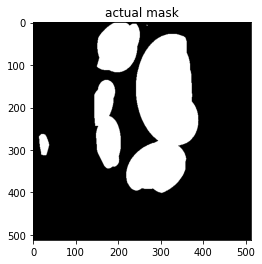

Predicted


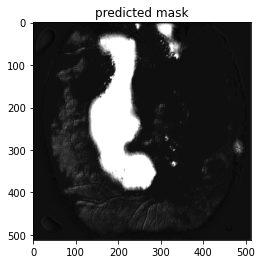

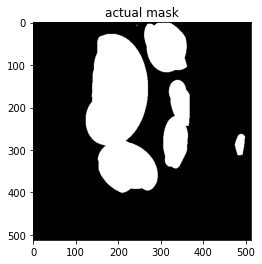

Predicted


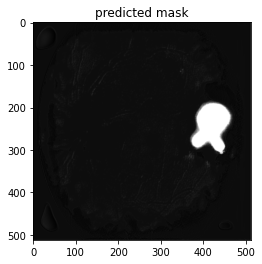

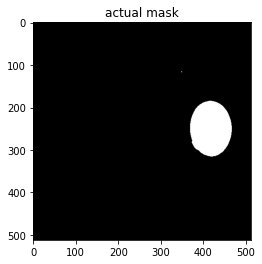

Predicted


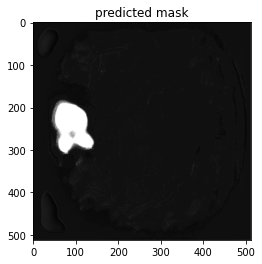

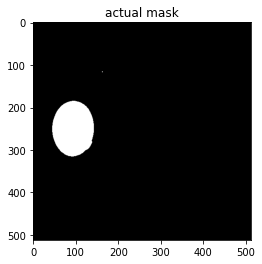

Predicted


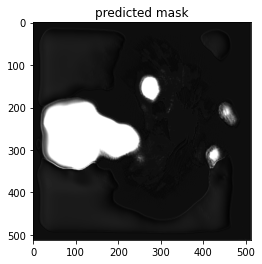

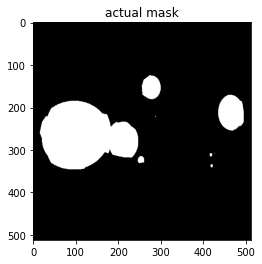

Predicted


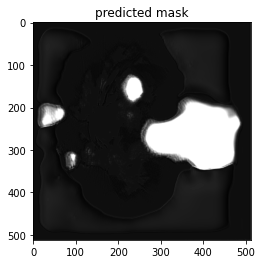

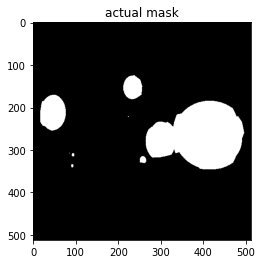

In [29]:
print(predicted_test_label[0].shape)
for i in range(14):
  print("Predicted")
  plt.imshow(np.squeeze(predicted_train_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("predicted mask")
  plt.show()
  plt.imshow(np.squeeze(train_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("actual mask")
  plt.show()

In [31]:
#serialize and save model 
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile()
print("Model loaded")

Loaded model from disk
Model loaded


In [33]:
pred_test_label_loaded_mod=loaded_model.predict(test_batch)

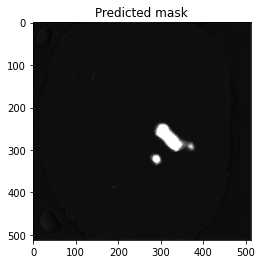

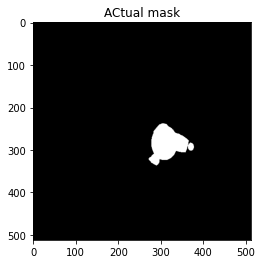

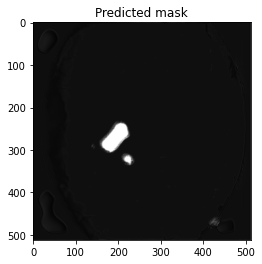

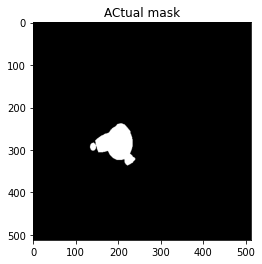

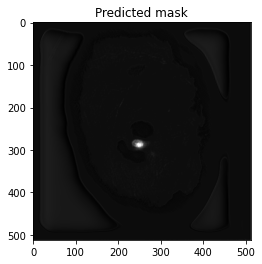

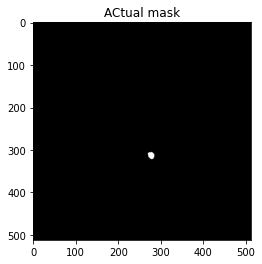

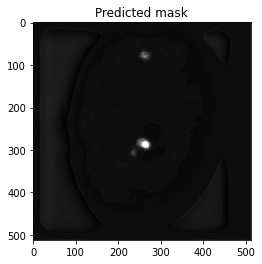

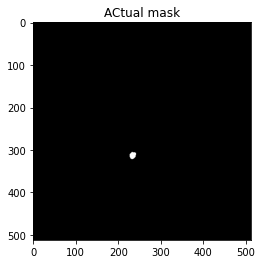

In [34]:
for i in range(4):
  plt.imshow(np.squeeze(pred_test_label_loaded_mod[i,:,:,:],axis=2),cmap='gray')
  plt.title("Predicted mask")
  plt.show()
  plt.imshow(np.squeeze(test_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("ACtual mask")
  plt.show()

In [37]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.round(test_label.reshape(-1)),np.round(pred_test_label_loaded_mod.reshape(-1)))

0.7097587307326134

# test set scores

In [38]:
testy, yhat_classes=(np.round(test_label.reshape(-1)),np.round(pred_test_label_loaded_mod.reshape(-1)))

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.992868
Precision: 0.882321
Recall: 0.420153
F1 score: 0.569240


# train set scores

In [40]:
testy, yhat_classes=(np.round(train_label.reshape(-1)),np.round(predicted_train_label.reshape(-1)))

In [41]:
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.980555
Precision: 0.934084
Recall: 0.718530
F1 score: 0.812250
